In [1]:
import tensorflow as tf
import rasterio
import numpy as np
from sklearn.preprocessing import minmax_scale
import cv2
import os

import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline
        
print(f'TensorFlow built with cuda? {tf.test.is_built_with_cuda()}')
print(f'TensorFlow built with GPU support? {tf.test.is_built_with_gpu_support()}')

2024-06-21 22:51:15.354410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 22:51:15.388008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow built with cuda? True
TensorFlow built with GPU support? True


In [2]:
!ls images

J-29-C-1-O-6.jgw	  J-29-C-4-M-3.jpg.aux.xml  J-29-C-5-M-5.jpg
J-29-C-1-O-6.jpg	  J-29-C-4-M-6.jgw	    J-29-C-5-M-5.jpg.aux.xml
J-29-C-1-O-6.jpg.aux.xml  J-29-C-4-M-6.jpg	    J-29-C-5-M-6.jgw
J-29-C-1-O-9.jgw	  J-29-C-4-M-6.jpg.aux.xml  J-29-C-5-M-6.jpg
J-29-C-1-O-9.jpg	  J-29-C-4-M-9.jgw	    J-29-C-5-M-6.jpg.aux.xml
J-29-C-1-O-9.jpg.aux.xml  J-29-C-4-M-9.jpg	    J-29-C-5-M-7.jgw
J-29-C-1-P-4.jgw	  J-29-C-4-M-9.jpg.aux.xml  J-29-C-5-M-7.jpg
J-29-C-1-P-4.jpg	  J-29-C-4-N-1.jgw	    J-29-C-5-M-7.jpg.aux.xml
J-29-C-1-P-4.jpg.aux.xml  J-29-C-4-N-1.jpg	    J-29-C-5-M-8.jgw
J-29-C-1-P-5.jgw	  J-29-C-4-N-1.jpg.aux.xml  J-29-C-5-M-8.jpg
J-29-C-1-P-5.jpg	  J-29-C-4-N-2.jgw	    J-29-C-5-M-8.jpg.aux.xml
J-29-C-1-P-5.jpg.aux.xml  J-29-C-4-N-2.jpg	    J-29-C-5-M-9.jgw
J-29-C-1-P-6.jgw	  J-29-C-4-N-2.jpg.aux.xml  J-29-C-5-M-9.jpg
J-29-C-1-P-6.jpg	  J-29-C-4-N-3.jgw	    J-29-C-5-M-9.jpg.aux.xml
J-29-C-1-P-6.jpg.aux.xml  J-29-C-4-N-3.jpg	    J-29-C-5-N-1.jgw
J-29-C-1-P-7.jgw	  J-29-C-4-N-3.jpg.aux.xml  

In [5]:
base_dir = './images/overlap'

images_dir ='./images/overlap/tiles'
masks_dir = './images/overlap/masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

random_images = np.random.choice(images_listdir, size = 9, replace = False)

print(len(images_listdir))
print(len(masks_listdir))

159
159


In [6]:
random_images

array(['J-29-C-5-N-7_36.jpg', 'J-29-C-5-M-5_34.jpg',
       'J-29-C-5-N-6_16.jpg', 'J-29-C-5-M-9_47.jpg',
       'J-29-C-5-M-9_86.jpg', 'J-29-C-5-M-5_32.jpg',
       'J-29-C-5-M-9_59.jpg', 'J-29-C-5-P-1_12.jpg',
       'J-29-C-5-N-6_35.jpg'], dtype='<U19')

In [9]:
image_size = 1024
input_image_size = (1024, 1024)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

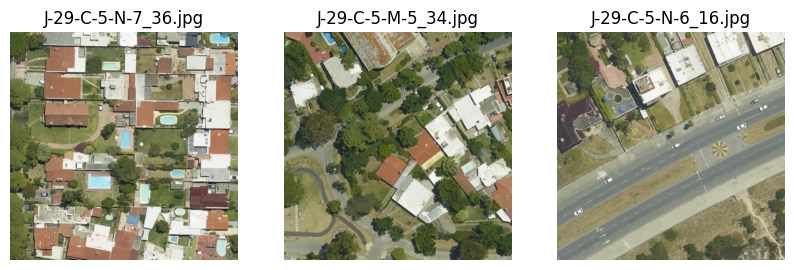

In [10]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        input_path = f"{images_dir}/{random_images[i]}"
        img = read_image(input_path)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

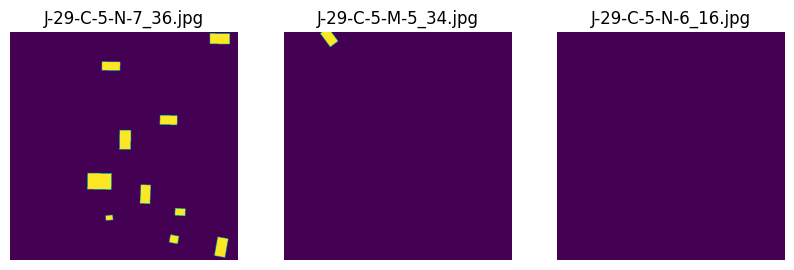

In [11]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [13]:
MASKS = np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES = np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

number=30

for j,file in enumerate(masks_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        file2=file[0:-4]+'.jpg'
        mask = read_image(f"{masks_dir}/{file2}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

J-29-C-5-M-9_54.jpg
J-29-C-5-M-5_14.jpg
J-29-C-5-N-7_2.jpg
J-29-C-5-M-2_29.jpg
J-29-C-5-N-7_9.jpg
J-29-C-5-M-9_82.jpg
J-29-C-5-O-3_30.jpg
J-29-C-5-M-2_39.jpg
J-29-C-5-N-5_88.jpg
J-29-C-5-O-3_81.jpg
J-29-C-5-N-5_78.jpg
J-29-C-5-M-9_46.jpg
J-29-C-5-O-3_92.jpg
J-29-C-5-N-7_4.jpg
J-29-C-5-N-6_5.jpg
J-29-C-5-M-9_34.jpg
J-29-C-5-M-9_75.jpg
J-29-C-5-N-7_24.jpg
J-29-C-5-M-9_94.jpg
J-29-C-5-N-7_14.jpg
J-29-C-5-O-3_40.jpg
J-29-C-5-M-5_31.jpg
J-29-C-5-N-5_66.jpg
J-29-C-5-M-5_43.jpg
J-29-C-5-N-7_5.jpg
J-29-C-5-N-7_36.jpg
J-29-C-5-M-9_88.jpg
J-29-C-5-N-5_87.jpg
J-29-C-5-M-9_45.jpg
J-29-C-5-N-7_45.jpg


In [14]:
TMASKS=np.zeros((1,image_size, image_size,1), dtype=bool)
TIMAGES=np.zeros((1,image_size, image_size,3),dtype=np.uint8)

for j,file in enumerate(test_images_listdir): ##the smaller, the faster
    try:
        image = read_image(f"{test_images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        TIMAGES = np.vstack([TIMAGES, image_ex])
        file2=file[0:-4]+'.jpg'
        mask = read_image(f"{test_masks_dir}/{file2}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        TMASKS = np.vstack([TMASKS, mask_ex])
    except:
        print(file)
        continue

NameError: name 'test_images_listdir' is not defined